# Data Wrangling

## Librerias

### Instalacion

### Importacion

In [81]:
import re
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

## Carga Datos

In [82]:
dfFinalSet = pd.read_csv('FinalSet.csv', dtype = {'codigoencabezado': 'int32'})

dfFinalSet.describe(include = 'all')

,codigoencabezado,idregistro,linkpagina,fecharegistro,fechalimpieza,administracion,amueblado,antiguedad,banos,habitaciones,...,moneda,tipo,tipo_vendedor,favoritos,titulo,fecha_creacion,valido_hasta,descripcion,partner_code,user_id
count,5569.000000,5.569000e+03,5569,5569,5569,1190.000000,3310,2627,5561.000000,5538.000000,...,5569,5561,4300,5569.000000,5569,5569,5569,5569,1107,5.569000e+03
unique,NaN,NaN,2743,15,2,NaN,2,8,NaN,NaN,...,2,6,3,NaN,2542,2739,2453,2748,754,NaN
top,NaN,NaN,https://www.olx.com.gt/item/apartamento-en-ven...,2020-06-25,2020-07-11,NaN,No,Hasta 5 años,NaN,NaN,...,US$,Apartamento,Inmobiliaria,NaN,"Alquilo Apartamento en Villa Risho, zona 14 | ...",2020-05-14T17:23:53-06:00,2020-10-14T05:23:05-06:00,"Fácil acceso por Villa Nueva, Petapa, Villa Ca...",PAA-011-03-20-2-R,NaN
freq,NaN,NaN,15,610,5080,NaN,2584,859,NaN,NaN,...,3546,5422,3616,NaN,20,15,20,17,9,NaN
mean,2785.839828,1.096580e+09,NaN,NaN,NaN,510.795798,NaN,NaN,1.959180,2.302636,...,NaN,NaN,NaN,2.268630,NaN,NaN,NaN,NaN,NaN,3.910065e+07
std,1608.009192,1.308418e+07,NaN,NaN,NaN,3409.053475,NaN,NaN,1.014795,0.802603,...,NaN,NaN,NaN,11.134723,NaN,NaN,NaN,NaN,NaN,2.626175e+07
min,1.000000,9.305465e+08,NaN,NaN,NaN,0.000000,NaN,NaN,0.000000,1.000000,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,2.843723e+06
25%,1394.000000,1.100259e+09,NaN,NaN,NaN,0.000000,NaN,NaN,1.000000,2.000000,...,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,1.569436e+07
50%,2786.000000,1.100378e+09,NaN,NaN,NaN,0.000000,NaN,NaN,2.000000,2.000000,...,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,2.745098e+07
75%,4178.000000,1.100417e+09,NaN,NaN,NaN,111.000000,NaN,NaN,2.000000,3.000000,...,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN,6.306340e+07


## Data Wrangling

En esta seccion prepararemos el set de datos que se utilizara para realizar la construccion del modelo de regresion. Primero definiremos los valores de flag para indicar que acciones se aplicaran sobre los datos.

In [83]:
# Normalizacion de datos para columna espacio_m2
flagDataNormalization = True

### Registros Unicos

Obtendremos solo los valores mas actualizados de los registros. Utilizaremos el atributo **idregistro** como identificador unico de los registros.

In [84]:
# Conversion a string del campo idregistro
dfAnalisisSet = dfFinalSet.astype({'idregistro': 'str'})

# Conversion a fecha del campo fecharegsitro
dfAnalisisSet['fecharegistro'] = pd.to_datetime(dfAnalisisSet['fecharegistro'], format = "%Y-%m-%d")

# Obtencion de fecha maxima por cada idregistro y filtro de esos registros.
dfAnalisisSet = dfAnalisisSet.loc[dfAnalisisSet.reset_index().groupby(['idregistro'])['fecharegistro'].idxmax()]

# Verificamos la cantidad de registros faltantes
dfAnalisisSet.shape

(2717, 27)

### Columna Precio Real

Procedemos a crear una columna llamada **precio_real** para establecer el precio en quetzales. Para los registros que tienen un precio en dolares se aplicara el factor de conversion a quetzales.

In [85]:
# Factor de conversion
cambio_moneda = 7.69

# Creacion de nueva columna
dfAnalisisSet['precio_real'] = np.where(dfAnalisisSet['moneda'] == 'US$', dfAnalisisSet['precio'] * cambio_moneda, 
                                        dfAnalisisSet['precio'])

# Visualizams los valores de precio real
dfAnalisisSet['precio_real']

2538    2299310.0
4049    1461100.0
1885    1207330.0
1886     922800.0
1876       6000.0
          ...    
643      544999.0
4055    2499250.0
2553        900.0
5362      23070.0
3555    4921600.0
Name: precio_real, Length: 2717, dtype: float64

### Columna Oferta

Procederemos a crear una columna llamada oferta para determinar si es una venta o alquiler de apartamento. Para ello vamos a especificar un valor pivote en la columna precio. Todo valor superior al valor pivote sera considerado como una venta.

In [86]:
# Asignacion de valor pivote
intValorPivote = 50000

# Creacion de nueva columna oferta.
dfAnalisisSet['oferta'] = ['Venta' if precio > intValorPivote else 'Alquiler' for precio in dfAnalisisSet['precio_real']]

# Verificamos cuantos registros quedaron en el dataset
dfAnalisisSet.groupby(['oferta']).count()['codigoencabezado']

oferta
Alquiler    1568
Venta       1149
Name: codigoencabezado, dtype: int64

### Filtro Inicial

Los primeros filtros a aplicar a nuestro set de datos son los siguientes:
* Tipo de oferta como Venta, ya que solo nos interesa realizar el modelo para apartamentos en venta.
* Amueblado con valor No, ya que segun el analisis para las ventas no hay data para este atributo.
* El tipo se especificara como "Apartamento" ya que es la clasificacion que posee mayor cantidad de registros.

In [87]:
# Especificamos los filtros
dfFiltradoSet = dfAnalisisSet[(dfAnalisisSet['oferta'] == 'Venta') & 
                              ((dfAnalisisSet['amueblado'] == 'No') | (dfAnalisisSet['amueblado'].isnull())) &
                             (dfAnalisisSet['tipo'] == 'Apartamento')]

# Verificamos las dimensiones
dfFiltradoSet.shape

(1120, 29)

Ahora especificamos las columnas que utilizaremos en principio para la construccion del set de datos

In [88]:
# Seleccionando las columnas a utilizar
dfFiltradoSet = dfFiltradoSet[['idregistro', 'banos', 'habitaciones', 
                               'espacio_m2', 'latitud', 'longitud', 'moneda',
                               'parqueo', 'tipo_vendedor', 'precio_real', 'user_id']]

dfFiltradoSet.shape

(1120, 11)

### Nueva Variable Ubicacion (KMeans)

Se procedera a crear una nueva variable llamada ubicacion que sera el numero de cluster asignado dependiendo de los valores de longitud y latitud.

In [135]:
dfFiltradoSet[['longitud', 'latitud']]

,longitud,latitud
2538,-90.506,14.591
4049,-90.508,14.635
1885,-90.511,14.600
1886,-90.491,14.593
1468,-90.503,14.588
...,...,...
799,-90.500,14.586
710,-90.512,14.592
643,-90.465,14.652
4055,-90.508,14.595


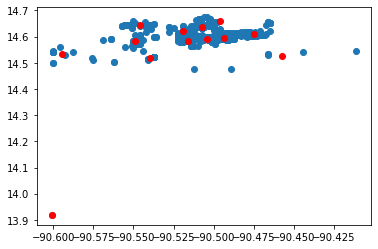

In [136]:
# Seleccion de numero de clusters.
# Nota: En Notebook Data Analysis podriamos identificar la cantidad de cluster por medio de elbow plot
intKClusters = 13

# Se obtienen los valores que se utilizaran para la construccion de modelo KMeans
#npUbicaciones = np.array(list(zip(dfFiltradoSet['longitud'], 
#                                  dfFiltradoSet['latitud']))).reshape(len(dfFiltradoSet['longitud']), 2)

# Construccion del modelo
kmeanModel = KMeans(n_clusters = intKClusters, max_iter = 2000).fit(dfFiltradoSet[['longitud', 'latitud']])

#kmeanModel.cluster_centers_
from matplotlib import pyplot as plt
plt.scatter(dfFiltradoSet['longitud'], dfFiltradoSet['latitud'])
plt.scatter(kmeanModel.cluster_centers_[:, 0], kmeanModel.cluster_centers_[:, 1], c='red')
plt.show()

#dfTemp['categoria'] = kmeanModel.labels_.unique()


# Asignacion de clusters a registros
#dfFiltradoSet['ubicacion'] = ["U" + str(ubicacion) for ubicacion in kmeanModel.labels_]

# Verificacion de la nueva columna
#dfFiltradoSet.head(10)

In [181]:
frecCat = np.unique(kmeanModel.labels_, return_counts = True)
dfCategorias = pd.DataFrame({'categoria': frecCat[0], 
                  'frecuencia': frecCat[1], 
                  'longitud': kmeanModel.cluster_centers_[:,0],
                  'latitud': kmeanModel.cluster_centers_[:,1]})

dfCategorias = dfCategorias.loc[dfCategorias['frecuencia'] > 10]

centroids = dfCategorias[['longitud', 'latitud']].to_numpy()

# Construccion del modelo
kmeanModel2 = KMeans(init = centroids, n_clusters = len(dfCategorias.index), max_iter = 2000)\
                .fit(dfFiltradoSet[['longitud', 'latitud']])

np.unique(kmeanModel2.labels_, return_counts = True)

kmeanModel2.predict(pd.DataFrame({'longitud':[-90.506, -90.508], 'latitud': [14.591, 14.635]}))


C:\Users\yadde\miniconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  del sys.path[0]


,U0,U1,U2,U3,U4,U5,U6,U7,U8,U9,U10,prueba,prueba2
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,11


### Filtro Baja Frecuencia (Ubicacion)

Verificaremos para la variable **ubicacion** del dataframe la frecuencia de sus valores para dejar aquellos que se encuentran bien representados.

In [60]:
srFreqUbicacion = pd.Series(dfFiltradoSet['ubicacion']).value_counts()
srFreqUbicacion

U0     313
U5     246
U4     163
U8     132
U2     123
U9      35
U7      33
U6      27
U3      18
U10     14
U11      9
U12      6
U1       1
Name: ubicacion, dtype: int64

In [61]:
# Eliminando elementos que tienen baja frecuencia para ubicacion
intNumeroPivote = 10
idxEliminar = srFreqUbicacion[srFreqUbicacion <= intNumeroPivote].index
dfFiltradoSet = dfFiltradoSet[~dfFiltradoSet.ubicacion.isin(idxEliminar)]

# Creamos el dataframe con el cual vamos a mapear los valores
dfMapeo = pd.DataFrame({'ubicacion': dfFiltradoSet.ubicacion.unique()})
dfMapeo['nueva_ubicacion'] = ["U" + str(ubicacion) for ubicacion in range(1, len(dfMapeo) + 1)]

# Colocamos los nuevos valores de ubicacion
dfFiltradoSet['ubicacion'] = dfFiltradoSet.join(dfMapeo.set_index('ubicacion'), on = 'ubicacion')['nueva_ubicacion']

# Verificamos que valores quedaron
srFreqUbicacion = pd.Series(dfFiltradoSet['ubicacion']).value_counts()
srFreqUbicacion

U3     313
U1     246
U4     163
U2     132
U8     123
U5      35
U7      33
U10     27
U9      18
U6      14
Name: ubicacion, dtype: int64

### Manejo valores nulos

#### Validacion variables con valores nulos
Procedemos a verificar cuales son las variables que presentan valores nulos

In [62]:
dfFiltradoSet.isnull().sum()

idregistro         0
banos              0
habitaciones       0
espacio_m2         0
latitud            0
longitud           0
moneda             0
parqueo           25
tipo_vendedor    523
precio_real        0
user_id            0
ubicacion          0
dtype: int64

#### Tratamiento Valores Nulos Parqueo
Primero verificaremos los rangos de valores para la variable **parqueo**.

In [63]:
srFreqParqueo = pd.Series(dfFiltradoSet['parqueo']).value_counts(dropna = False)
srFreqParqueo

Si     666
No     413
NaN     25
Name: parqueo, dtype: int64

Vamos a utilizar la columna de descripcion para verificar si tiene la columna parqueo. De ser asi, se les colocara que si posee parqueo.

In [64]:
# Obtenemos la info de los registros que tienen parqueo como nulo.
dfSinParqueo = dfFiltradoSet.loc[pd.isnull(dfFiltradoSet['parqueo']), ['idregistro', 'parqueo']]

# Obtenemos la info de los regsitros del catalogo inicial solo para los registros de interes.
dfCatalogo = dfAnalisisSet.loc[dfAnalisisSet.idregistro.isin(dfSinParqueo['idregistro']), ['idregistro', 'descripcion']]

# Verificamos si existe palabra parqueo dentro de columna descripcion
dfCatalogo['parqueo'] = ["Si" if (re.search('parqueo',str(descripcion).lower())) else "No" \
                         for descripcion in dfCatalogo['descripcion']]

# Asignacion de los valores calculados para parqueo
dfFiltradoSet = dfFiltradoSet.set_index(['idregistro'])\
    .combine_first(dfCatalogo[['idregistro', 'parqueo']].set_index(['idregistro']))\
    .reset_index()


# Verificamos si existe palabra parqueo dentro de columna descripcion
dfFiltradoSet['parqueo'] = [1 if (parqueo == "Si") else 0 for parqueo in dfFiltradoSet['parqueo']]

# Verificacion del parqueo
srFreqParqueo = pd.Series(dfFiltradoSet['parqueo']).value_counts(dropna = False)
srFreqParqueo

1    687
0    417
Name: parqueo, dtype: int64

#### Tratamiento Valores Nulos Tipo Vendedor

In [65]:
srFreqVendedor = pd.Series(dfFiltradoSet['tipo_vendedor']).value_counts(dropna = False)
srFreqVendedor

Inmobiliaria     550
NaN              523
Dueño Directo     31
Name: tipo_vendedor, dtype: int64

In [66]:
# Obtenemos los codigos de vendedor donde el tipo_vendedor es nulo.
dfSinVendedor = dfFiltradoSet.loc[pd.isnull(dfFiltradoSet['tipo_vendedor']), ['idregistro', 'tipo_vendedor', 'user_id']]

# Calculamos la frecuencia de registros para cada user_id
srFreqVendedores = pd.Series(dfSinVendedor['user_id']).value_counts(dropna = False)

# Para aquellos user_id que solo poseen un registro se les asigna el valor de "Dueno Directo"
intNumeroPivote = 1
idxDuenos = srFreqVendedores[srFreqVendedores == intNumeroPivote].index
dfSinVendedor['tipo_vendedor'] = ["Dueño Directo" if x else "Inmobiliaria" for x in dfSinVendedor.user_id.isin(idxDuenos)]

# Asignacion de los valores calculados para tipo de vendedor
dfFiltradoSet = dfFiltradoSet.set_index(['idregistro'])\
    .combine_first(dfSinVendedor[['idregistro', 'tipo_vendedor']].set_index(['idregistro']))\
    .reset_index()

dfFiltradoSet.loc[953]
# Verificacion del tipo de vendedor
#srFreqParqueo = pd.Series(dfFiltradoSet['tipo_vendedor']).value_counts(dropna = False)
#srFreqParqueo

idregistro         1100438641
banos                       3
espacio_m2                171
habitaciones                3
latitud                14.591
longitud              -90.512
moneda                    US$
parqueo                     1
precio_real       1.84475e+06
tipo_vendedor    Inmobiliaria
ubicacion                  U1
user_id              39763788
Name: 953, dtype: object

### Data Normalization

El objetivo es normalizar  la columna de espacio que tiene una escala mayor a diferencia de las otras variables. Para la normalizacion se utilizara Z score.

In [67]:
#dfFiltradoSet['espacio_m2'] = (dfFiltradoSet['espacio_m2'] - dfFiltradoSet['espacio_m2'].min()) / (dfFiltradoSet['espacio_m2'].max() - dfFiltradoSet['espacio_m2'].min())

dfFiltradoSet

,idregistro,banos,espacio_m2,habitaciones,latitud,longitud,moneda,parqueo,precio_real,tipo_vendedor,ubicacion,user_id
0,1007688385,3.0,232.0,3.0,14.591,-90.506,US$,1,2299310.00,Inmobiliaria,U1,55074295
1,1009069375,3.0,120.0,2.0,14.635,-90.508,US$,1,1461100.00,Inmobiliaria,U2,63063400
2,1014321966,2.0,78.0,1.0,14.600,-90.511,US$,1,1207330.00,Inmobiliaria,U1,34408653
3,1014324725,2.0,65.0,2.0,14.593,-90.491,US$,1,922800.00,Inmobiliaria,U3,34408653
4,1023944274,2.0,74.0,2.0,14.588,-90.503,US$,1,1647474.84,Inmobiliaria,U1,24012106
...,...,...,...,...,...,...,...,...,...,...,...,...
1099,1100464679,2.0,86.0,3.0,14.592,-90.520,US$,1,1368820.00,Inmobiliaria,U1,32785066
1100,1100464828,2.0,84.0,3.0,14.586,-90.500,US$,1,999700.00,Inmobiliaria,U1,56587551
1101,1100465920,3.0,76.0,2.0,14.592,-90.512,US$,1,1418512.78,Inmobiliaria,U1,23432107
1102,930546537,3.0,260.0,2.0,14.595,-90.508,US$,1,2499250.00,Inmobiliaria,U1,20592158


### Hot Encoding

Vamos a crear dummy variables para aquellas variables que son de tipo categorico. Primero verificaremos los tipos de datos del actual dataframe.

In [68]:
dfFiltradoSet.dtypes

idregistro        object
banos            float64
espacio_m2       float64
habitaciones     float64
latitud          float64
longitud         float64
moneda            object
parqueo            int64
precio_real      float64
tipo_vendedor     object
ubicacion         object
user_id            int64
dtype: object

In [69]:
# Eliminamos variables dummy si ya existen
dfFiltradoSet = dfFiltradoSet.drop(['moneda_q','moneda_d', 'tipo_inmobiliaria', 'tipo_dueno'], axis=1, errors='ignore')

# Convertimos aquellas variables categoricas a variables dummy.
dfFiltradoSet = pd.concat([dfFiltradoSet, pd.get_dummies(dfFiltradoSet['moneda'])\
                              .rename(columns={'Q': 'moneda_q', 'US$': 'moneda_d'})], axis = 1)

dfFiltradoSet = pd.concat([dfFiltradoSet, pd.get_dummies(dfFiltradoSet['tipo_vendedor'])\
                              .rename(columns={'Inmobiliaria': 'tipo_inmobiliaria', 
                                               'Dueño Directo': 'tipo_dueno'})], axis = 1)

dfFiltradoSet = pd.concat([dfFiltradoSet, pd.get_dummies(dfFiltradoSet['ubicacion'])], axis = 1)

# Verificamos las variables resultantes
dfFiltradoSet.dtypes

idregistro            object
banos                float64
espacio_m2           float64
habitaciones         float64
latitud              float64
longitud             float64
moneda                object
parqueo                int64
precio_real          float64
tipo_vendedor         object
ubicacion             object
user_id                int64
moneda_q               uint8
moneda_d               uint8
tipo_dueno             uint8
tipo_inmobiliaria      uint8
U1                     uint8
U10                    uint8
U2                     uint8
U3                     uint8
U4                     uint8
U5                     uint8
U6                     uint8
U7                     uint8
U8                     uint8
U9                     uint8
dtype: object

### Seleccion Variables Modelo

In [70]:
# Generar las variables de ubicacion
variables_ubicacion =["U" + str(ubicacion) for ubicacion in [*range(1, len(dfMapeo) + 1)]]
variables_set = ['idregistro', 'banos', 'espacio_m2', 
                               'habitaciones', 'moneda_q', 'moneda_d',
                               'parqueo', 'tipo_dueno', 'tipo_inmobiliaria', 
                               'precio_real'
                              ]
# Seleccion de las variables
dfModeloSet = dfFiltradoSet[dfFiltradoSet.columns.intersection(variables_ubicacion + variables_set)]

# Verificacion de las variables
dfModeloSet.dtypes

idregistro            object
banos                float64
espacio_m2           float64
habitaciones         float64
parqueo                int64
precio_real          float64
moneda_q               uint8
moneda_d               uint8
tipo_dueno             uint8
tipo_inmobiliaria      uint8
U1                     uint8
U10                    uint8
U2                     uint8
U3                     uint8
U4                     uint8
U5                     uint8
U6                     uint8
U7                     uint8
U8                     uint8
U9                     uint8
dtype: object

## Construccion Modelo

In [190]:
# Seleccionamos las variables predictoras
dfPredictors = dfModeloSet.loc[:, ~dfModeloSet.columns.isin(['precio_real', 'idregistro'])]

# Seleccionamos la variable dependiente
Y = dfModeloSet['precio_real']

# Separamos los datos para test y training
xTrain, xTest, yTrain, yTest = train_test_split(dfPredictors, Y, test_size = 0.3, random_state=1505)

xTrain.dtypes

banos                float64
espacio_m2           float64
habitaciones         float64
parqueo                int64
moneda_q               uint8
moneda_d               uint8
tipo_dueno             uint8
tipo_inmobiliaria      uint8
U1                     uint8
U10                    uint8
U2                     uint8
U3                     uint8
U4                     uint8
U5                     uint8
U6                     uint8
U7                     uint8
U8                     uint8
U9                     uint8
dtype: object

In [191]:
dfModeloSet.loc[dfModeloSet['idregistro'] == '1100413514']

,idregistro,banos,espacio_m2,habitaciones,parqueo,precio_real,moneda_q,moneda_d,tipo_dueno,tipo_inmobiliaria,U1,U10,U2,U3,U4,U5,U6,U7,U8,U9
843,1100413514,2.0,121.0,3.0,0,1418651.2,0,1,0,1,0,0,0,1,0,0,0,0,0,0


In [192]:

dfTemp = dfModeloSet.loc[~dfModeloSet.index.isin(xTrain.index)]

dfTemp = pd.DataFrame(dfTemp[dfTemp.columns].dtypes).reset_index()

dfTemp.columns = ['nombrecampo', 'tipodatacampo']

dfTemp

,nombrecampo,tipodatacampo
0,idregistro,object
1,banos,float64
2,espacio_m2,float64
3,habitaciones,float64
4,parqueo,int64
5,precio_real,float64
6,moneda_q,uint8
7,moneda_d,uint8
8,tipo_dueno,uint8
9,tipo_inmobiliaria,uint8


### Regresion Lineal

Se crea modelo de regresion lineal multivariable utilizando los datos de entrenamiento. Verificamos que obtenemos los valores de coeficiente y de intercepto.

In [193]:
# Construccion del modelo
linearRegModel = LinearRegression()

linearRegModel.fit(xTrain, yTrain)

# Verificacion de coeficientes
linearRegModel.coef_

array([  85975.27339808,   12985.78556357,  -55751.8901623 ,
        157614.10577966,  -23689.58764401,   23689.58764401,
        -89081.07078159,   89081.07078159,  104009.75875926,
       -148695.00962134,   24983.59195387,  173969.1156708 ,
        129993.45429427, -129003.43207154, -138034.17458658,
        -30196.0338024 ,  262699.4517589 , -249726.72235523])

In [194]:
# Verificacion de intercepto
linearRegModel.intercept_

-373610.6655760454

#### Validacion

[Text(0, 0.5, 'Densidad'),
 Text(0.5, 0, 'Precio (Q)'),
 Text(0.5, 1.0, 'Regresion Lineal Multivariable')]

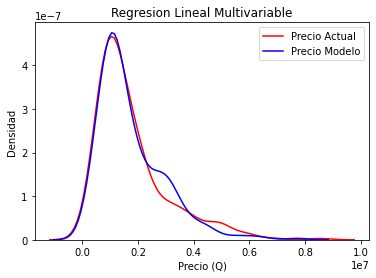

In [195]:
# Obtenemos las predicciones del modelo para los datos test
yHat = linearRegModel.predict(xTest)

# Verificamos con un grafico de distribucion la prediccion del modelo
ax1 = sns.distplot(yTest, hist = False, color = "r", label = "Precio Actual")
sns.distplot(yHat, hist = False, color = "b", label = "Precio Modelo", ax = ax1)
ax1.set(title = "Regresion Lineal Multivariable", xlabel='Precio (Q)', ylabel='Densidad')

#### MSE & R^2

In [196]:
# Calculo de metricas
mseLinearRegModel = mean_squared_error(yTest, yHat)
r2LinearRegModel = r2_score(yTest, yHat)

mseLinearRegModel

376438712205.0342

In [197]:
r2LinearRegModel

0.7760756515568852

### Random Forest Regressor

In [198]:
# Construccion del modelo
randomForestModel = RandomForestRegressor(n_estimators = 200, max_depth = 20, random_state = 1505)

randomForestModel.fit(xTrain, yTrain)

RandomForestRegressor(max_depth=20, n_estimators=200, random_state=1505)

#### Validacion

[Text(0, 0.5, 'Densidad'),
 Text(0.5, 0, 'Precio (Q)'),
 Text(0.5, 1.0, 'Random Forest Regressor')]

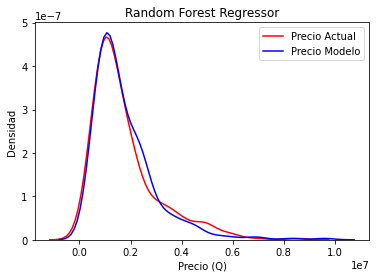

In [199]:
# Obtenemos las predicciones del modelo para los datos test
yHat = randomForestModel.predict(xTest)

# Verificamos con un grafico de distribucion la prediccion del modelo
ax1 = sns.distplot(yTest, hist = False, color = "r", label = "Precio Actual")
sns.distplot(yHat, hist = False, color = "b", label = "Precio Modelo", ax = ax1)
ax1.set(title = "Random Forest Regressor", xlabel='Precio (Q)', ylabel='Densidad')

#### MSE & R^2

In [200]:
# Calculo de metricas
mseRandomForestModel = mean_squared_error(yTest, yHat)
r2RandomForestModel = r2_score(yTest, yHat)

mseRandomForestModel

364104495485.3591

In [201]:
r2RandomForestModel

0.7834126531801536

In [204]:
dfT = dfModeloSet.loc[dfModeloSet['idregistro'] == '1007688385', ~dfModeloSet.columns.isin(['idregistro', 'precio_real'])]

dfT

,banos,espacio_m2,habitaciones,parqueo,moneda_q,moneda_d,tipo_dueno,tipo_inmobiliaria,U1,U10,U2,U3,U4,U5,U6,U7,U8,U9
0,3.0,232.0,3.0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0
